In [1]:
#Importing required modules
from lxml import objectify
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import geopy
from geopy.geocoders import Nominatim, ArcGIS, GoogleV3, GeoNames
import shapely.geometry as geom
import geopandas as gpd
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.lines as mlines
csfont = {'fontname':'Arial'}

In [2]:
#Scrubing XML file of dog runs and dog friendly parks from NYC parks
page = requests.get('https://www.nycgovparks.org/bigapps/DPR_DogRuns_001.xml')

In [3]:
#getting the root node from the XML file
root = ET.fromstring(page.content)

In [4]:
#Validating the 1st children node form the root node
root.getchildren()[0].getchildren()

C:\Users\juanpablo\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  from ipykernel import kernelapp as app


[<Element '{http://www.nycgovparks.org/bigapps/desc/DPR_DogRuns_001.txt}Prop_ID' at 0x10792978>,
 <Element '{http://www.nycgovparks.org/bigapps/desc/DPR_DogRuns_001.txt}Name' at 0x107929e8>,
 <Element '{http://www.nycgovparks.org/bigapps/desc/DPR_DogRuns_001.txt}Address' at 0x10792a20>,
 <Element '{http://www.nycgovparks.org/bigapps/desc/DPR_DogRuns_001.txt}DogRuns_Type' at 0x10792a58>,
 <Element '{http://www.nycgovparks.org/bigapps/desc/DPR_DogRuns_001.txt}Accessible' at 0x10792a90>,
 <Element '{http://www.nycgovparks.org/bigapps/desc/DPR_DogRuns_001.txt}Notes' at 0x10792ac8>]

In [5]:
#Creating a empty dataframe to store the XML info
dogruns = pd.DataFrame(columns=('Prop_ID', 'Name', 'Adress', 'DogRuns_Type', 'Accesible', 'Notes'))

In [6]:
#Processing a loop to store all child nodes in the dataframe
for i in range(0,len(root)):
    obj = root.getchildren()[i].getchildren()
    row = dict(zip(['Prop_ID', 'Name', 'Adress', 'DogRuns_Type', 'Accesible', 'Notes'], [obj[0].text, obj[1].text, obj[2].text, \
               obj[3].text, obj[4].text, obj[5].text,]))
    row_s = pd.Series(row)
    row_s.name = i
    dogruns = dogruns.append(row_s)

C:\Users\juanpablo\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  app.launch_new_instance()


In [7]:
#Visualizaing the head of the new resulting dataframe
dogruns.head()

,Prop_ID,Name,Adress,DogRuns_Type,Accesible,Notes
0,X002,Bronx Park Off-Leash Area,Unionport & Sagamore on Bronx Park East to 233...,Off-Leash,N,None
1,X008,Claremont Park Off-Leash Area,None,Off-Leash,N,None
2,X010,Crotona Park Off-Leash Area,Except for playgrounds and other areas where d...,Off-Leash,N,None
3,X013,Devoe Park Off-Leash Area,192nd & Jerome Avenue,Off-Leash,N,None
4,X019,Ewen Park Dog Run,"Riverdale to Johnson avenues, south of West 23...",Run,N,None


In [8]:
#Defining a function for geocoding - Thanks for Xia Wang for the snippet
def geocoding(fname, coder, col, n_init, n_end):
    '''
    This function takes 5 arguments: fname, coder, col, n_init, n_end
    fname: the pandas dataframe you want to geocode
    coder: geocoder of your choice
    col: the column containing the address you want to geocode
    n_init: the starting index
    n_end: the finishing index
    '''
    # create two rows: 'lat' and 'lon' for the data
    fname['lat'] = 0
    fname['lon'] = 0
    geolocator = coder
    for i in fname[col].index[n_init:n_end+1]:
        try:
            loc = geolocator.geocode(fname[col][i])
            fname.ix[i, 'lat'] = loc.latitude
            fname.ix[i, 'lon'] = loc.longitude
        except:
            print 'number %i Error' %i 
            fname.ix[i, 'lat'] = 'Error'
            fname.ix[i, 'lon'] = 'Error'
    return fname

In [9]:
#Modifying the names of the parks and dog runs to allow the Google API to find thee location of them
dogruns['Name'] = dogruns['Name'].replace(to_replace='Off-Leash Area', value="",regex=True)
dogruns['Name'] = dogruns['Name'].replace(to_replace='Dog Run', value="",regex=True)
dogruns['Name'] = dogruns['Name'] + " NYC"

In [10]:
#Modifying the name of two specific parks that are probelmatic for Google to locate
dogruns['Name'].ix[8] = 'Highland Park NYC'
dogruns['Name'].ix[16] = 'Spuyten Duyvil Shorefront Park'
dogruns['Name'].ix[44] = 'Macri Triangle Park NYC'
dogruns['Name'].ix[39] = 'J.J. Byrne Dog Park NYC'
dogruns['Name'].ix[69] = 'Madison Square Park NYC'

In [11]:
#Applying the geocoding function
new = geocoding(fname = dogruns, coder = GoogleV3(), col = 'Name',
                n_init = 0, n_end = 135)

number 69 Error


In [12]:
#Visualizaing the new dataframe with the lat and lon values
new

,Prop_ID,Name,Adress,DogRuns_Type,Accesible,Notes,lat,lon
0,X002,Bronx Park NYC,Unionport & Sagamore on Bronx Park East to 233...,Off-Leash,N,None,40.8605,-73.8743
1,X008,Claremont Park NYC,None,Off-Leash,N,None,40.8409,-73.9054
2,X010,Crotona Park NYC,Except for playgrounds and other areas where d...,Off-Leash,N,None,40.8395,-73.8956
3,X013,Devoe Park NYC,192nd & Jerome Avenue,Off-Leash,N,None,40.8631,-73.9062
4,X019,Ewen Park NYC,"Riverdale to Johnson avenues, south of West 23...",Run,N,None,40.8819,-73.9099
5,X110A,Frank S. Hackett Park NYC,Riverdale Avenue at Henry Hudson Parkway,Run,N,None,40.7128,-74.0059
6,X047,Franz Sigel Park NYC,"Center of the park, just north of the ballfiel...",Run,N,None,40.8231,-73.9253
7,X080,Henry Hudson Park NYC,Kappock Street and Independence Avenue,Off-Leash,N,None,40.8442,-73.9449
8,X010,Highland Park NYC,Except for playgrounds and other areas where d...,Off-Leash,N,None,40.6887,-73.8863
9,X015,Joseph Rodham Drake Park NYC,None,Off-Leash,N,None,40.8104,-73.8825


In [13]:
#Creating two new dataframes, one with dog runs and the other with off-leash parks
new2 = new[(new['lon']!='Error') & (new['DogRuns_Type'] == "Off-Leash")]
new3 = new[(new['lon']!='Error') & (new['DogRuns_Type'] == "Run")]

In [14]:
#Creating a subsample of the lon and lat for each class
longlat = new2[['lon', 'lat']]
longlat2 = new3[['lon', 'lat']]

In [15]:
#Creating geodatapoints for the first class and project them to CRS3395
points = map(geom.Point, longlat.as_matrix().tolist())
gpos = gpd.GeoSeries(points)
epsg4326 = {'init': 'epsg:4326'}
gpos.crs = epsg4326
projectedPos = gpos.to_crs(epsg=3395)

In [16]:
#Creating geodatapoints for the first class and project them to CRS3395
points2 = map(geom.Point, longlat2.as_matrix().tolist())
gpos2 = gpd.GeoSeries(points2)
epsg4326 = {'init': 'epsg:4326'}
gpos2.crs = epsg4326
projectedPos2 = gpos2.to_crs(epsg=3395)

In [17]:
#Importing a geojson with the shapes for NYC ZIP codes
zipcodes = gpd.GeoDataFrame.from_file('NYCZIPS.geojson')
zipcodes = zipcodes.to_crs(epsg=3395)

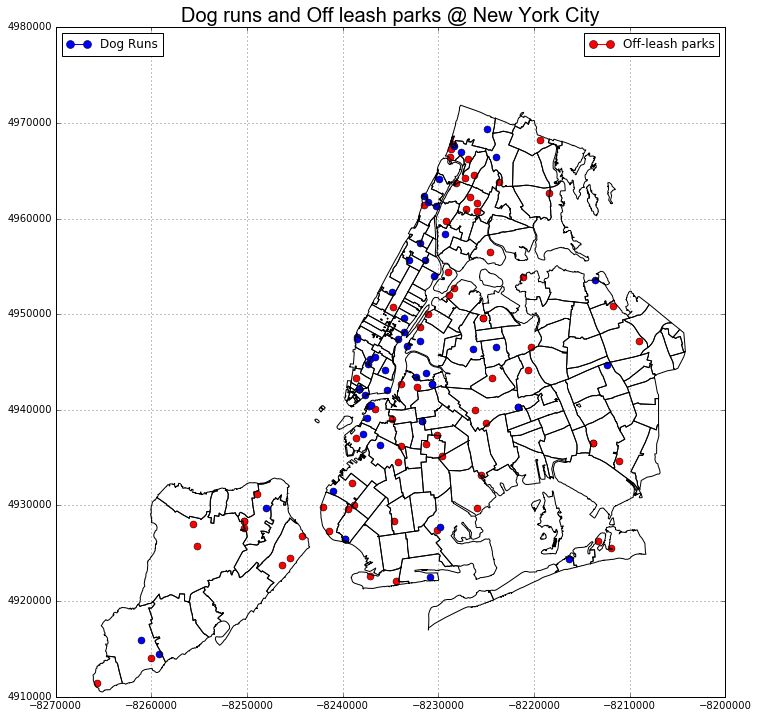

In [18]:
#Plotting the resulting frames (geopoints) on the Zip code map
fig = plt.figure()
base = projectedPos.plot(alpha=1.0, figsize=(12,12), marker='o', color='red', markersize=7)
projectedPos2.plot(ax=base, alpha=1.0, figsize=(12,12), marker='o', color='blue', markersize=7)
zipcodes.plot(ax = base, alpha=0, figsize = (12,12))
plt.grid()
plt.title("Dog runs and Off leash parks @ New York City", fontsize=20, **csfont)
blue_line = mlines.Line2D([],[], color='blue', marker='o',
                          markersize=8, label='Dog Runs')
red_line = mlines.Line2D([],[], color='red', marker='o',
                          markersize=8, label='Off-leash parks')
first_legend = plt.legend(handles=[red_line], loc=1)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[blue_line], loc=2)

In [37]:
#Importing a shapefile with the shapes for NYC ZIP codes and dog density
dogsum = gpd.GeoDataFrame.from_file('dog_1.geojson')

In [38]:
#Showing columns for the geeodataframe
dogsum.columns

Index([       u'@id', u'BLDGpostal',   u'CTY_FIPS', u'Dog Densit',
        u'Number of',   u'OBJECTID',    u'PO_NAME',      u'STATE',
          u'ST_FIPS', u'Zipcode Ar',    u'borough',   u'geometry',
         u'latitude',  u'longitude', u'postalCode'],
      dtype='object')

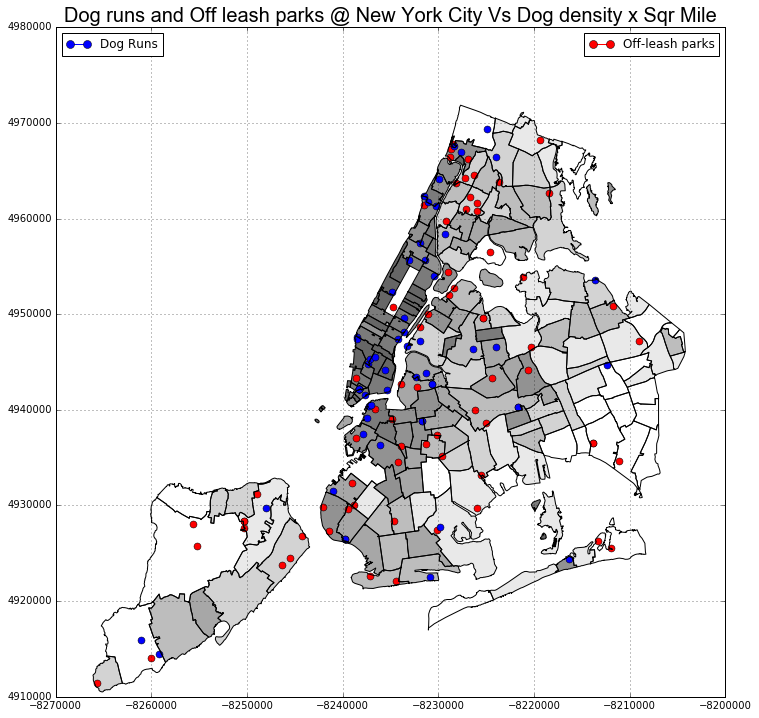

In [49]:
#Plotting imported shapefile
#Plotting the resulting frames (geopoints) on the Zip code map
fig = plt.figure()
base = projectedPos.plot(alpha=1.0, figsize=(12,12), marker='o', color='red', markersize=7)
projectedPos2.plot(ax=base, alpha=1.0, figsize=(12,12), marker='o', color='blue', markersize=7)
dogsum.plot(ax=base, column='Dog Densit', alpha=0.6, scheme = 'QUANTILES', k=8, cmap='gray_r', figsize = (12,12), legend=True)
plt.grid()
plt.title("Dog runs and Off leash parks @ New York City Vs Dog density x Sqr Mile", fontsize=20, **csfont)
blue_line = mlines.Line2D([],[], color='blue', marker='o',
                          markersize=8, label='Dog Runs')
red_line = mlines.Line2D([],[], color='red', marker='o',
                          markersize=8, label='Off-leash parks')
first_legend = plt.legend(handles=[red_line], loc=1)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[blue_line], loc=2)